In [1]:
#General
import numpy as np
import pandas as pd

#Data Retrieval and Visualization
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#Statistical Package
from scipy import stats 
from numpy import log10, polyfit, var, subtract
from statsmodels import regression
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts


/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
spy_etf=web.DataReader('SPY','yahoo','2010-01-01','2020-01-01' ) 

In [9]:
#spy_etf.reset_index(drop=True,inplace=True)
spy_etf.head()


,High,Low,Open,Close,Volume,Adj Close,Y_hat
Date,,,,,,,
2009-12-31,112.800003,111.389999,112.769997,111.440002,90637900.0,90.310234,71.154488
2010-01-04,113.389999,111.510002,112.370003,113.330002,118944600.0,91.841896,71.240145
2010-01-05,113.680000,112.849998,113.260002,113.629997,111579900.0,92.084984,71.325803
2010-01-06,113.989998,113.430000,113.519997,113.709999,116074400.0,92.149803,71.411461
2010-01-07,114.330002,113.180000,113.500000,114.190002,131091100.0,92.538841,71.497119


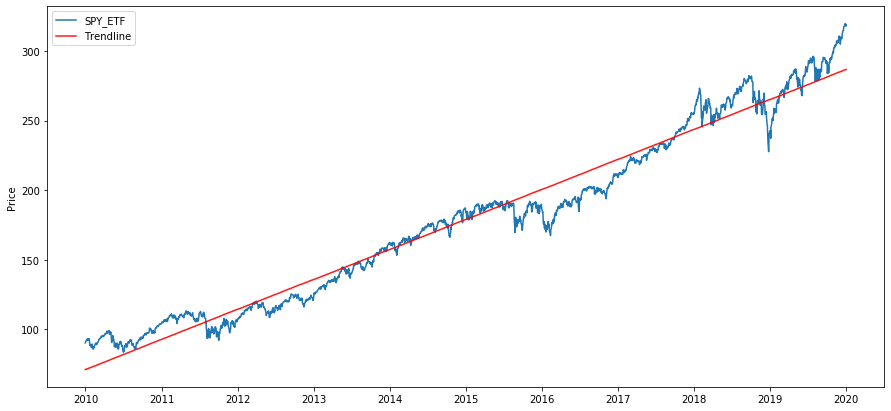

In [8]:
plt.figure(figsize=(15,7))
plt.plot(spy_etf['Adj Close'])

# Find the line of best fit to illustrate the trend
X = np.arange(len(spy_etf['Adj Close'].index))
x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
model = regression.linear_model.OLS(spy_etf['Adj Close'], x).fit()
a = model.params[0] # Get coefficients of line
b = model.params[1]
spy_etf['Y_hat'] = X * b + a
plt.plot(spy_etf['Y_hat'], 'r', alpha=0.9);
plt.ylabel('Price')
plt.legend(['SPY_ETF', 'Trendline']);
plt.show()

## ADF Test for Stationary
Null Hypothesis: The series has a unit root 

Alternate Hypothesis: The series has no unit root. [Stationary]



In [10]:
def adf_test(ticker):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    adf_test = adfuller(np.log(ticker), autolag='AIC')
    dfoutput = pd.Series(adf_test[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series

adf_test(spy_etf['Adj Close'])


Results of Dickey-Fuller Test:
Test Statistic                   -0.608018
P-value                           0.869160
#Lags Used                       25.000000
Number of Observations Used    2491.000000
Critical Value (1%)              -3.432978
Critical Value (5%)              -2.862701
Critical Value (10%)             -2.567388
dtype: float64


ADF Test statistics is always positive for trend following and negative for mean reversion. We can also see the p-value is 0.881719,means it is non stationary.
Since your adfuller P-value is higher than a certain specified alpha (i.e.: 5%), then you fail reject the null hypothesis (Ho), because the probability of getting a P-value as high as that by mere luck (random chance) is very likely.

# Finding Correlations between Returns of Different Time Frames
Null Hypothesis: No Correlation

Alternative Hypothesis: Correlation

P-value represent the probability for the null hyptohesis. Find the optimal pair of past and future periods that give highest positive correlation

In [21]:
def correlation_Opt(ts):
    ts.reset_index(drop=True,inplace=True)
    lookback=[5,10,25,60,120,180,250]
    holddays =[5,10,25,60,120,180,250]
    dfObj=pd.DataFrame(columns=['Look-back' , 'Holding days', 'Correlation Coefficient' , 'P-Value"'])
    for look in lookback:
        for hold in holddays:
           #Lag and Fut return
            ret_lag=(ts-ts.shift(look))/ts.shift(look)
            ret_fut=(ts.shift(-hold)-ts)/ts
            #Remove row with nan values
            df=pd.concat([ret_lag,ret_fut],axis=1)
            df.columns=['lag','fut']
            df.dropna(inplace=True)
            df.reset_index(drop=True,inplace=True)
            ret_lag=df['lag']
            ret_fut=df['fut']
            #Remove overlapping data 
            if (look>=hold):
                indepSet=np.arange(0,len(ret_lag)+1,look)
            else:
                indepSet=np.arange(0,len(ret_lag)+1,hold)
            
            ret_lag=ret_lag[indepSet]
            ret_fut=ret_fut[indepSet]
            cor,p_val=stats.pearsonr(ret_lag,ret_fut)
            dfObj = dfObj.append(pd.Series([look, hold, cor, p_val], index=dfObj.columns ), ignore_index=True)
    print (dfObj)
correlation_Opt(spy_etf['Adj Close'])

    Look-back  Holding days  Correlation Coefficient  P-Value"
0         5.0           5.0                -0.055958  0.052238
1         5.0          10.0                -0.093636  0.021578
2         5.0          25.0                -0.143307  0.026420
3         5.0          60.0                 0.075696  0.454146
4         5.0         120.0                 0.029932  0.836523
5         5.0         180.0                 0.389689  0.024979
6         5.0         250.0                -0.090381  0.674485
7        10.0           5.0                 0.030792  0.450783
8        10.0          10.0                -0.029859  0.465002
9        10.0          25.0                -0.054255  0.402740
10       10.0          60.0                -0.035387  0.726692
11       10.0         120.0                -0.008005  0.956000
12       10.0         180.0                 0.315671  0.073527
13       10.0         250.0                 0.250261  0.238216
14       25.0           5.0                 0.106483  0

As can be seen, there is a compromise between correlation coefficient and p-value. Select the one with the highest correlation and lowest p-value as our optimal trading range

## Hurst Exponent
Hurst exponent $H$ indicates whether a time series is stationary ($H<0.5$), random ($H=0.5$), or trending ($H>0.5$)

In [18]:
from numpy import log10, polyfit, var, subtract

def hurst_function(ts, lag_range=None):
    ts = ts if not isinstance(ts, pd.Series) else ts.to_list()
    if len(ts)>lag_range:
        ts = log10(ts) # use log price

        variancetau = []
        tau = []
    
        #  Range of lag values
        if lag_range == None:
            lags = [2]
        else:
            lags = range(2, lag_range) # lag_range < len(ts)

        for lag in lags: 

            #  Write the different lags into a vector to compute a set of tau or lags
            tau.append(lag)

            # The price difference
            pp = subtract(ts[lag:], ts[:-lag])
            variancetau.append(np.std(pp))

        # Plot the log of corrseponding variance against the log of tau and get the slope
        m = polyfit(log10(tau),log10(variancetau),1)

        hurst = m[0]*2

        return hurst
    else:
        return 0

print("Hurst: %s" %hurst_function(spy_etf['Adj Close'].iloc[-550:],300) )
df=spy_etf



Hurst: 0.4253332752242513


In [24]:
for row in range(len(df)):
    if row > 500:
        df['hurst'].iloc[row]=hurst_function(df['Adj Close'].iloc[row-600:row],250)
                                            
    else:
        df['hurst'].iloc[row]=0
df.head()


,High,Low,Open,Close,Volume,Adj Close,Y_hat,hurst
Date,,,,,,,,
2009-12-31,112.800003,111.389999,112.769997,111.440002,90637900.0,90.310234,71.154488,0.0
2010-01-04,113.389999,111.510002,112.370003,113.330002,118944600.0,91.841896,71.240145,0.0
2010-01-05,113.680000,112.849998,113.260002,113.629997,111579900.0,92.084984,71.325803,0.0
2010-01-06,113.989998,113.430000,113.519997,113.709999,116074400.0,92.149803,71.411461,0.0
2010-01-07,114.330002,113.180000,113.500000,114.190002,131091100.0,92.538841,71.497119,0.0


## Alternative Hurst 
Var(τ)=(Var(z(t)-z(t-τ)))

In [22]:
# Calculate Hurst 
#Problem aries when you guys send series as the argument. You need to send a list not a series.
def hurst(ts):
    
    ts = ts if not isinstance(ts, pd.Series) else ts.to_list() # To Returns the Hurst Exponent of the time series vector ts
    lags = range(2, 360)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0
hurst(spy_etf['Adj Close'].iloc[-2000:])

0.31753033677233194

## Momentum Calculation by fitting a curve with exponential linear regression

In [2]:
def momentum(ts):
    returns=np.log(ts)
    x=np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x,returns)
    score=((1+slope)**252)*(rvalue**2)
    return score